In [ ]:
import numpy as np
from numba import jit, cuda 
import os
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import pickle 
from keras.optimizers import Adam
from keras.applications import resnet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
import pandas as pd
from skimage.segmentation import quickshift,felzenszwalb,slic
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.segmentation import mark_boundaries
import cv2
from skimage.measure import regionprops
import math
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Code To see avilable CPU and GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7147372119925490783
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10686122080152081185
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 975364479497186626
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15694933568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4886411915319611762
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
meta_data=pd.read_csv("/content/drive/My Drive/Dissertation/metadata.csv")

In [ ]:
#df_images_label1 = pd.read_pickle('/content/drive/My Drive/Dissertation/with_pic_pkl.pkl',nrows=5000)
df_images_label1 = pd.read_pickle('/content/drive/My Drive/Dissertation/with_pictorial_images.pkl')

In [ ]:
df_images_label1['ImgID']=df_images_label1.apply(lambda x: x['Label'][:-6], axis = 1).values

In [ ]:
df_merge_col = pd.merge(df_images_label1, meta_data, on = 'ImgID',how='inner')

In [ ]:
df_metadata_lat=pd.read_csv(r'/content/drive/My Drive/Dissertation/metadatalat.csv')

In [ ]:
df_merge_col_lat = pd.merge(df_merge_col, df_metadata_lat[['ImgID','ViewPosition']], on = 'ImgID',how='inner')

In [ ]:
df_merge_col_lat['PatientLabel_update'] = df_merge_col_lat.apply(lambda x: x['PatientLabel'] if (str(x['Laterality']) in str(x['LesionPositionLeft']) or str(x['Laterality']) in str(x['LesionPositionRight'])) else 'N',axis=1)

In [ ]:
df_merge_col_lat.drop(df_merge_col_lat.index[df_merge_col_lat['ViewPosition'] != 'MLO'], inplace = True)

In [ ]:
#di = {"M": 1, "CI": 1,"B": 0, "N": 0}
di = {"M": 1, "B": 0,"CI": 1, "N": 0}
df_merge_col_lat['PatientLabel_en']=df_merge_col_lat['PatientLabel_update'].map(di)

In [ ]:
df_merge_col_lat['PatientLabel_en'].value_counts()

0    4079
1    3969
Name: PatientLabel_en, dtype: int64

In [ ]:
X = np.array([i for i in df_merge_col_lat['Images']])
Y = [i for i in df_merge_col_lat['PatientLabel_en']]

In [ ]:
X1 = X.reshape((X.shape[0], 224, 224,3))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.2, random_state=42)
X_train, X_cv, y_train1, y_cv1 = train_test_split(X_train, y_train1, test_size=0.2, random_state=42)

In [ ]:
y_train = keras.utils.to_categorical(y_train1, 2)
y_test = keras.utils.to_categorical(y_test1, 2)
y_cv = keras.utils.to_categorical(y_cv1, 2)

#Resnet50

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
base_model = keras.applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (224,224,3))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
#x = Dropout(0.3)(x)
predictions = Dense(2, activation= 'softmax')(x)
model_1 = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from sklearn.metrics import roc_auc_score
def auc(y_true,y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
#, metrics=['accuracy']
from keras.optimizers import SGD
opt = Adam(lr=0.000001)
model_1.compile(optimizer=opt, loss='categorical_crossentropy',metrics=[auc])

In [ ]:
#,class_weight=class_weight
history=model_1.fit(X_train, y_train, epochs = 15, batch_size = 64,validation_data=(X_cv,y_cv))

In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

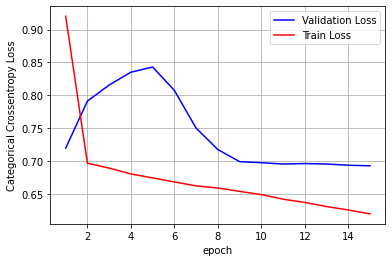

In [ ]:
nb_epoch=15
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,nb_epoch+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=model_1.predict(X_test)
#y_classes = keras.np_utils.probas_to_classes(y_pred)
y_pred_class = np.argmax(y_pred, axis=1)
cm=confusion_matrix(y_test1,y_pred_class)
print(cm)

[[414 382]
 [340 474]]


In [ ]:
from sklearn.metrics import roc_curve, auc
probs1 = model_1.predict(X_test)
probs = probs1[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_test1, probs)
roc_auc = auc(fpr1, tpr1)

In [ ]:
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic_auc(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation AUC")
    ax.plot(x, ty, 'r', label="Train AUC")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

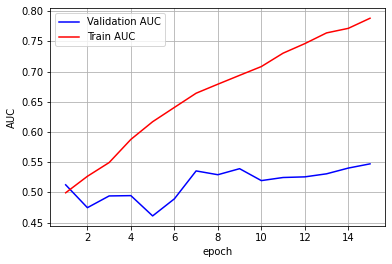

In [ ]:
nb_epoch=15
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_auc']
ty = history.history['auc']
plt_dynamic_auc(x, vy, ty, ax)

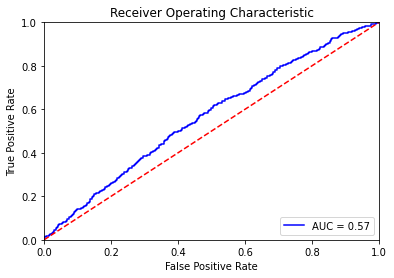

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

-------------------- Confusion matrix --------------------


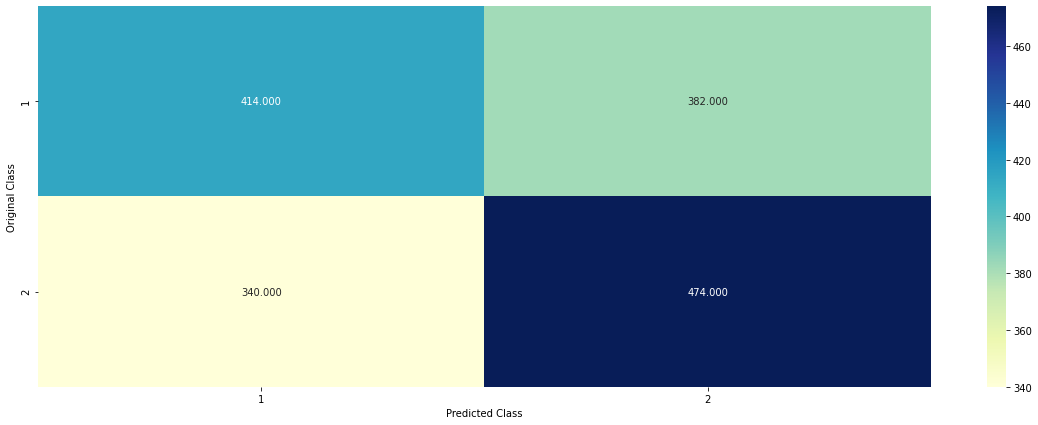

-------------------- Precision matrix (Columm Sum=1) --------------------


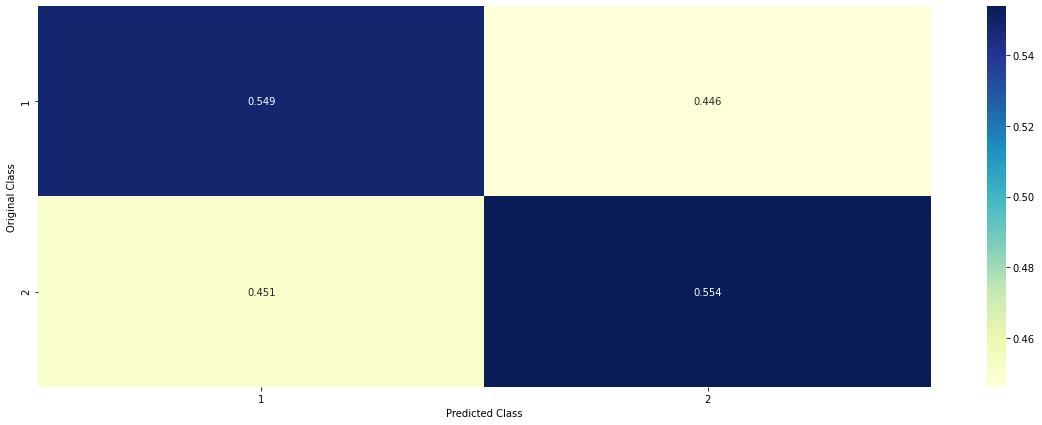

-------------------- Recall matrix (Row sum=1) --------------------


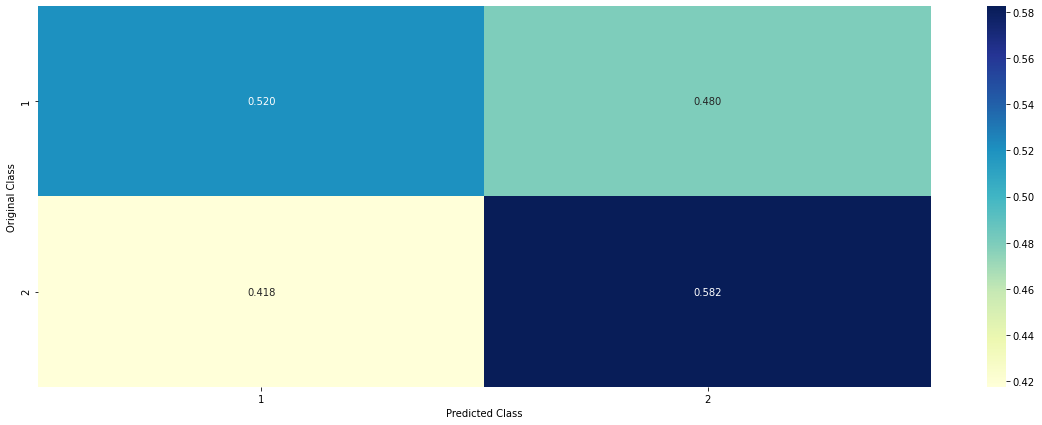

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test1,y_pred_class)

#VGG16

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

model_vgg16_conv = VGG19(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_vgg16_conv.summary()

x = model_vgg16_conv.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)



#Create your own model 
my_model = Model(inputs=model_vgg16_conv.input, outputs=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from sklearn.metrics import roc_auc_score
def auc(y_true,y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
from sklearn.metrics import roc_auc_score
opt = Adam(lr=0.000001)
my_model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=[auc])

In [ ]:
history_vgg=my_model.fit(X_train, y_train,batch_size=108,epochs=8,verbose=1,validation_data=(X_cv,y_cv))

Train on 5289 samples, validate on 1323 samples
Epoch 1/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 1.4884 - auc: 0.5237 - val_loss: 1.2414 - val_auc: 0.5111
Epoch 2/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 0.9529 - auc: 0.6006 - val_loss: 1.1082 - val_auc: 0.5116
Epoch 3/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 0.7652 - auc: 0.6735 - val_loss: 1.0553 - val_auc: 0.5309
Epoch 4/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 0.6353 - auc: 0.7464 - val_loss: 1.0165 - val_auc: 0.5440
Epoch 5/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 0.5437 - auc: 0.8081 - val_loss: 1.0069 - val_auc: 0.5393
Epoch 6/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 0.4662 - auc: 0.8634 - val_loss: 1.0069 - val_auc: 0.5436
Epoch 7/8
5289/5289 [==============================] - 75s 14ms/sample - loss: 0.4038 - auc: 0.9097 - val_loss: 1.0069 - val_auc: 

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=my_model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
cm=confusion_matrix(y_test1,y_pred_class)
print(cm)

[[444 371]
 [389 450]]


In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

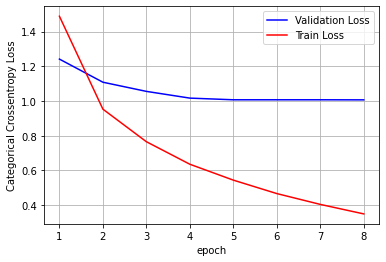

In [ ]:
#score = my_model.evaluate(X_test, y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])
nb_epoch=8
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history_vgg.history['val_loss']
ty = history_vgg.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
#import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
#, colors=['b']
def plt_dynamic_auc(x, vy, ty, ax,colors=['b']):
    ax.plot(x, vy, 'b', label="Validation AUC")
    ax.plot(x, ty, 'r', label="Train AUC")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    #plt.show()

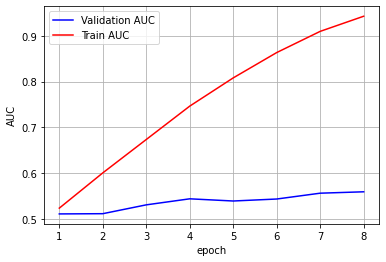

In [ ]:
#score = my_model.evaluate(X_test, y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])
nb_epoch=8
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('AUC')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history_vgg.history['val_auc']
ty = history_vgg.history['auc']
plt_dynamic_auc(x, vy, ty, ax)

In [ ]:
from sklearn.metrics import roc_curve, auc
probs1 = my_model.predict(X_test)
probs = probs1[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_test1, probs)
roc_auc = auc(fpr1, tpr1)

In [ ]:
roc_auc

0.5656807329789334

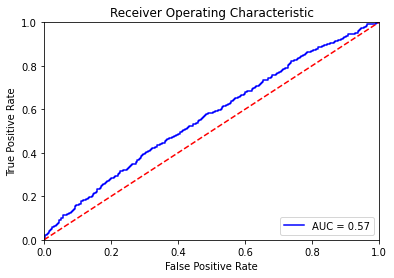

In [ ]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


-------------------- Confusion matrix --------------------


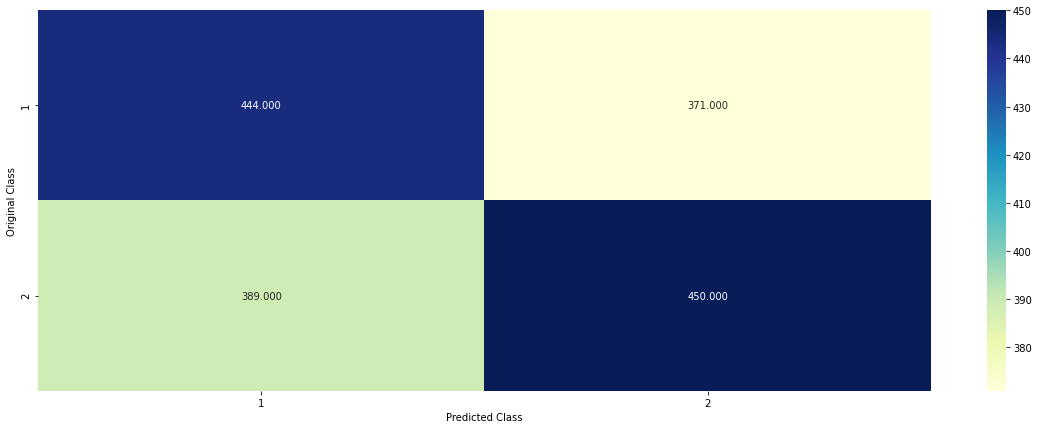

-------------------- Precision matrix (Columm Sum=1) --------------------


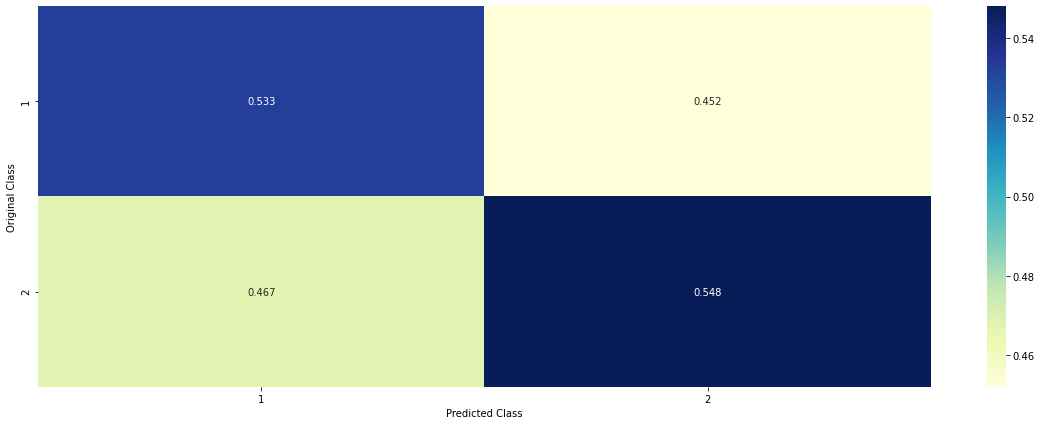

-------------------- Recall matrix (Row sum=1) --------------------


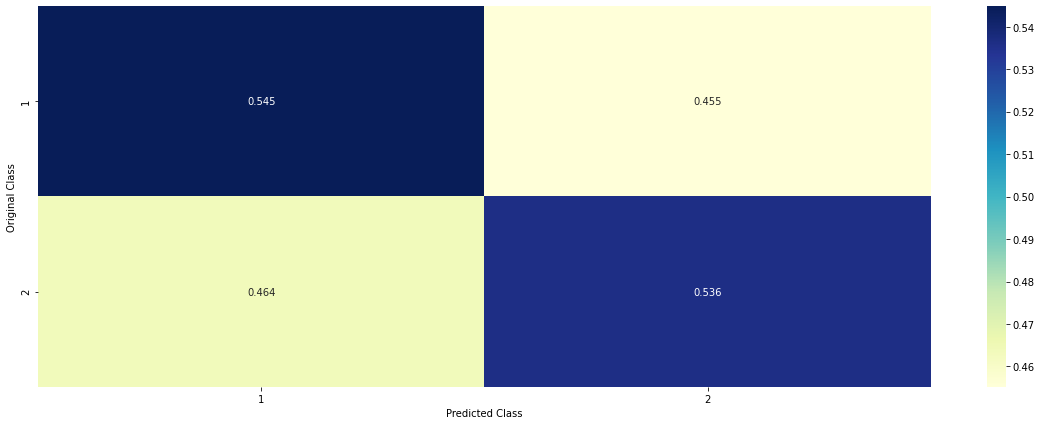

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(y_test1,y_pred_class)

#Code to transfer files from cloud bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'platinum-bebop-273122'
!gcloud config set project {project_id}
!gsutil ls


Updated property [core/project].
gs://platinum-bebop-273122-bucket/


In [ ]:
bucket_name = 'platinum-bebop-273122-bucket'
!gsutil -m cp -r  gs://{bucket_name}/with_pic_pkl.pkl  /content/drive/My\ Drive/Dissertation

Copying gs://platinum-bebop-273122-bucket/with_pic_pkl.pkl...
/ [1/1 files][  5.6 GiB/  5.6 GiB] 100% Done  52.9 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.6 GiB.                                      


In [ ]:
bucket_name = 'platinum-bebop-273122-bucket'
!gsutil -m cp -r  gs://{bucket_name}/segmented_files_sample/segmented_cc_sample/  /content/drive/My\ Drive/Dissertation/Images/segmented/segmented_cc_sample2

Streaming output truncated to the last 5000 lines.
Copying gs://platinum-bebop-273122-bucket/segmented_files_sample/segmented_cc_sample/1.2.826.0.1.3680043.9.3218.1.1.1535863.1478.1517659352036.4722.0_LC4_N.png...
Copying gs://platinum-bebop-273122-bucket/segmented_files_sample/segmented_cc_sample/1.2.826.0.1.3680043.9.3218.1.1.1535863.1478.1517659352036.4722.0_LD1_N.png...
Copying gs://platinum-bebop-273122-bucket/segmented_files_sample/segmented_cc_sample/1.2.826.0.1.3680043.9.3218.1.1.1535863.1478.1517659352036.4722.0_LD4_N.png...
Copying gs://platinum-bebop-273122-bucket/segmented_files_sample/segmented_cc_sample/1.2.826.0.1.3680043.9.3218.1.1.1535863.1478.1517659352036.4722.0_LE1_N.png...
Copying gs://platinum-bebop-273122-bucket/segmented_files_sample/segmented_cc_sample/1.2.826.0.1.3680043.9.3218.1.1.1535863.1478.1517659352036.4722.0_LD3_N.png...
Copying gs://platinum-bebop-273122-bucket/segmented_files_sample/segmented_cc_sample/1.2.826.0.1.3680043.9.3218.1.1.1535863.1478.15176